## Building an effective Point Spread Function (ePSF)

This notebook follows the photutils tutorial on building an effective PSF (https://photutils.readthedocs.io/en/stable/epsf.html#build-epsf) with scope to build onto PSF photometry (https://photutils.readthedocs.io/en/stable/psf.html) in order to apply the knowledge onto the example PAL 5 data.

A useful paper to read (completed: ??OCT2020), Anderson and King 2000 (https://ui.adsabs.harvard.edu/abs/2000PASP..112.1360A/abstract), shows that stellar photometry can be derived by modelling the net PSF which they called the effective PSF (ePSF). The ePSF is an empirical model which describes the fraction of a star's light will land inside a particular pixel.

### Building an ePSF

The following tutorial for photutils follows the Anderson and King 2000 paper.

First, a sample of stars must be defined for use to build the ePSF. These stars should be bright (a high S/N) and also isolated, preventing contamination by other stars. This can be done using source detection algorithms, or instead manual detection by viewing the image.

In this tutorial a simulated image will be loaded:

In [1]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils import datasets
from photutils.datasets import make_noise_image

hdu = datasets.load_simulated_hst_star_image()
data = hdu.data
data +=  make_noise_image(data.shape, distribution='gaussian', mean=10.,
                          stddev=5.)
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')

This example uses find_peaks() to identify stars and their initial positions: the threshold value is set to 500 to ensure only the brightest stars are found.

In [2]:
from photutils import find_peaks
peaks_tbl = find_peaks(data, threshold = 500.)
peaks_tbl['peak_value'].info.format = '%.8g'
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   849      2  1068.7878
   182      4  1713.1861
   324      4  3009.0709
   100      9  1144.1746
   824      9  1300.4333
   934     12  894.17943
   135     15   1488.936
   780     17  960.06746
   893     18  598.03163
   440     23  1245.1097
   ...    ...        ...
   437    985  1971.8861
   508    985  2635.5728
   984    987    739.692
   950    988  2689.5609
   168    991  1698.6187
   635    991  3613.3514
   751    992  804.94215
   114    994  1590.8623
   299    994  655.89025
   207    998  2795.0968
   691    999  2627.5246
Length = 431 rows


Some stars will be removed at this point due to crowding, however in this image it is unnecessary. Next, extracting cutouts of the stars using extract_stars() is required and stars near the boundary excluded:

In [4]:
size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']
y = peaks_tbl['y_peak']
mask= ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

# create a table of good star positions
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask]
stars_tbl['y'] = y[mask]

print(stars_tbl)

# subtract background from the image using sigma clipped as background does not vary across image
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = 2.)
data -= median_val

# extract_stars() requires input data as an NDData object
from astropy.nddata import NDData
nddata = NDData(data = data)

print(nddata)

 x   y 
--- ---
135  15
780  17
893  18
440  23
847  29
219  32
364  32
 47  36
817  36
593  37
... ...
354 953
 65 959
327 960
868 960
156 962
240 966
721 966
 92 969
571 971
437 985
508 985
Length = 404 rows
[[-9.82000217 -1.804288    4.43042074 ...  1.85985363 -0.91404143
  -3.08837833]
 [-1.08726541  6.42275223 -3.88841355 ...  5.19126337  1.20326113
  -0.9689861 ]
 [ 2.89811362 -5.62047508  4.34648604 ...  1.55824873 -6.87247878
  11.2647046 ]
 ...
 [-2.34152607 -0.93081797  5.24216958 ... -7.11029806  3.60027478
   3.17231819]
 [-3.45678573 -4.99910664 -4.20180725 ... -1.52517229  2.02164408
   1.5175564 ]
 [ 4.26171768 -2.52083129 -8.37073493 ... -0.3028032  -5.42927772
   1.58615019]]


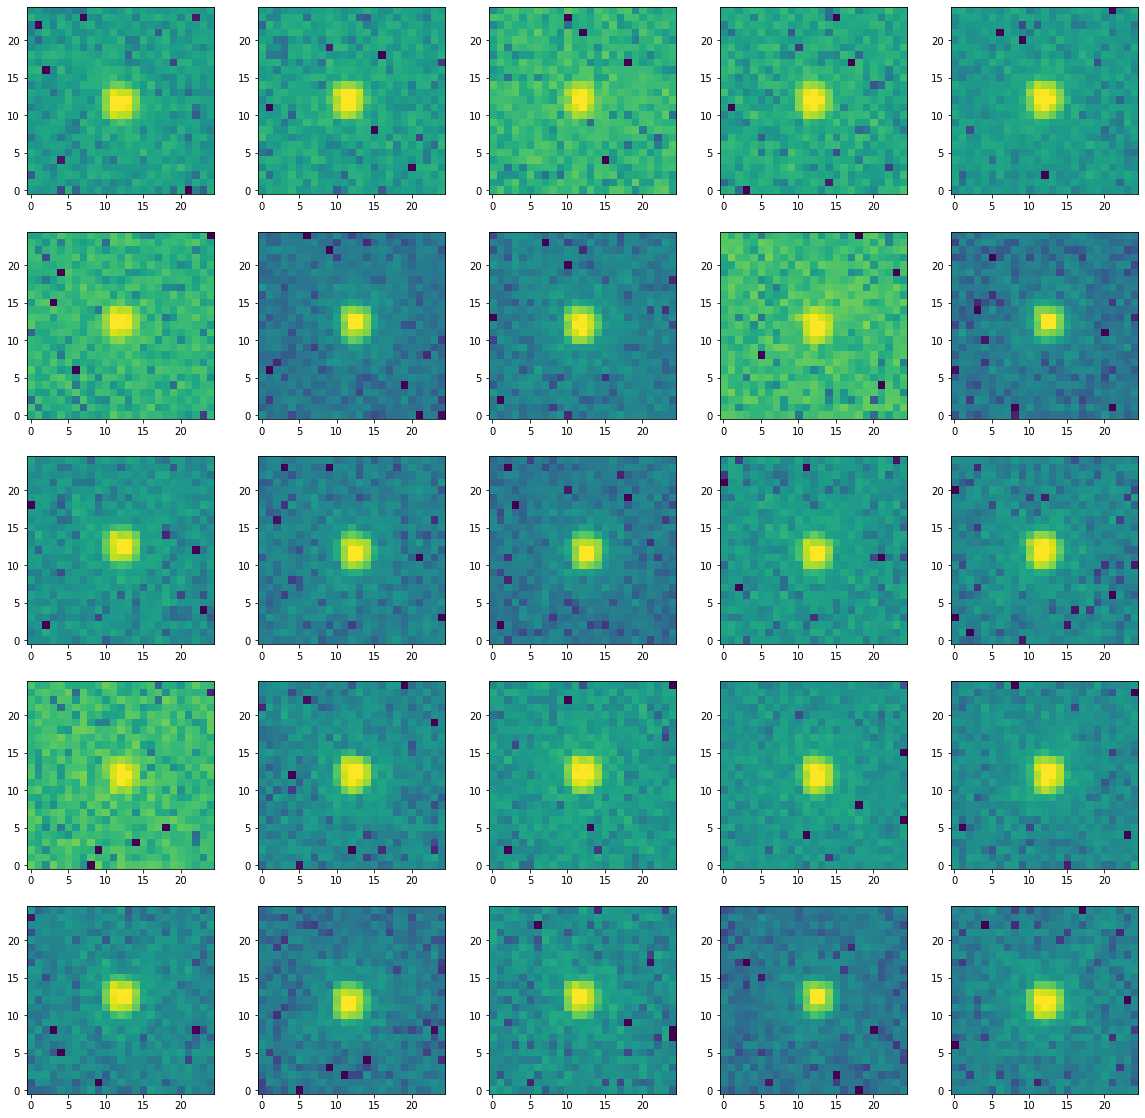

In [9]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size = 25)

# show the first 25 of extracted stars
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)

ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent = 99.)
    ax[i].imshow(stars[i], norm = norm, origin = 'lower', cmap = 'viridis')

Now that star cutouts have been obtained, it is time to construct the ePSF using the EPSFBuilder class. This will be done with an oversampling of 4.0 and run for 3 iterations (10 is more ideal for real world data).

First initialise an EPSFBuilder instance using the desired parameters and then input the cutouts of our selected stars into the instance:

In [10]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling = 4, maxiters = 3, progress_bar = False)

epsf, fitted_stars = epsf_builder(stars)

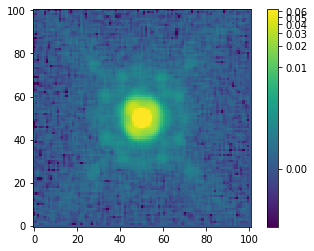

In [11]:
# visualise the constructed ePSF
norm = simple_norm(epsf.data, 'log', percent=99.)

plt.imshow(epsf.data, norm = norm, origin = 'lower', cmap = 'viridis')
plt.colorbar()